In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [160]:
def generate_sin_data(noise_scale):
    t = np.linspace(0, 2 * np.pi, 1000)
    y = np.sin(t)

    # add gaussian noise to outputs for train data
    train_data = np.sin(t) + np.random.normal(loc=0.0, scale=noise_scale, size=t.shape)

    return t, y, train_data


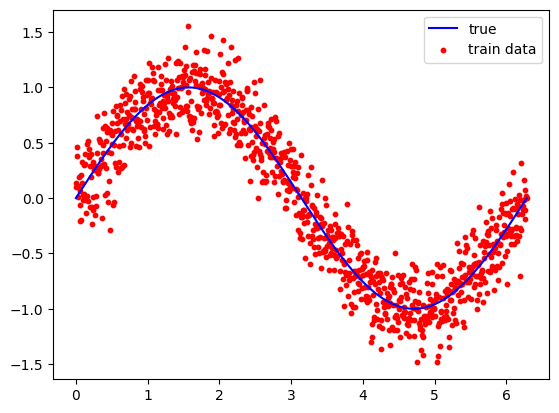

In [161]:
t, y, train_data = generate_sin_data(0.2)


plt.plot(t, y, color="blue", label="true")
plt.scatter(t, train_data, s=10, color="red", label="train data")
plt.legend(loc="upper right")

Basic NN

In [56]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    
    def forward(self, x):
        return self.model(x)

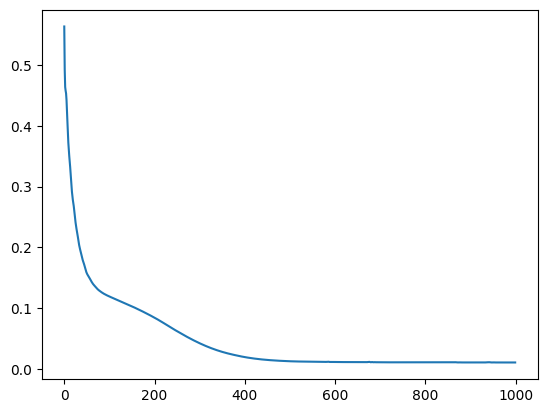

In [164]:
# initialize model and hyperparameters
model = NeuralNetwork()
criterion = nn.MSELoss()
num_epochs = 1000

# generate data
t, y, train_data = generate_sin_data(0.1)

# train model
losses = []
opt = torch.optim.Adam(model.parameters(), lr=0.001)

# convert to tensors
train_data = torch.FloatTensor(train_data.reshape(-1, 1))
t = torch.FloatTensor(t.reshape(-1, 1))

for epoch in range(num_epochs):
    
    predictions = model(t)
    loss = criterion(predictions, train_data)

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())

plt.plot(losses);

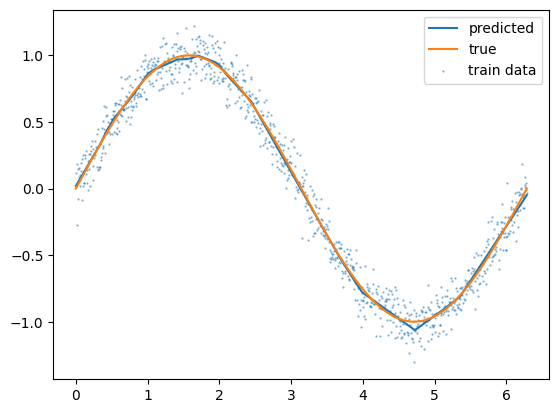

In [166]:
predicted = model(t)
plt.plot(t, predicted.detach(), label="predicted")
plt.plot(t, y, label="true")
plt.scatter(t, train_data, s=0.4, alpha=0.5, label="train data")
plt.legend(loc="upper right")

RNN Comparison

In [138]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(1, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(1, x.size(0), self.hidden_size)

        out, ht = self.rnn(x, h0)
        out = self.fc(out)
        return out, ht

In [133]:
hidden_size = 16
rnn = SimpleRNN(hidden_size)

In [139]:

# batch_size, sequence length, input size
# test_input = torch.tensor([[[0.1], [0.1]]])
test_input = torch.tensor([[[0.1]]])
print(test_input.shape)
out, ht = rnn.forward(test_input)

print(out)
print(ht)


torch.Size([1, 1, 1])
torch.Size([1, 1, 16])
tensor([[[0.0461]]], grad_fn=<ViewBackward0>)
tensor([[[ 0.1678,  0.1708,  0.4254,  0.2738, -0.2417, -0.0603, -0.0497,
           0.0448, -0.1005,  0.0925, -0.1658,  0.1541,  0.0246, -0.3717,
          -0.0526,  0.2705]]], grad_fn=<StackBackward0>)


In [170]:
def get_sequences_from_data(data, sequence_length):
    output = []

    for i in range(len(data) - sequence_length):

        sequence = data[i: i + sequence_length]
        output.append(sequence)
    
    return output

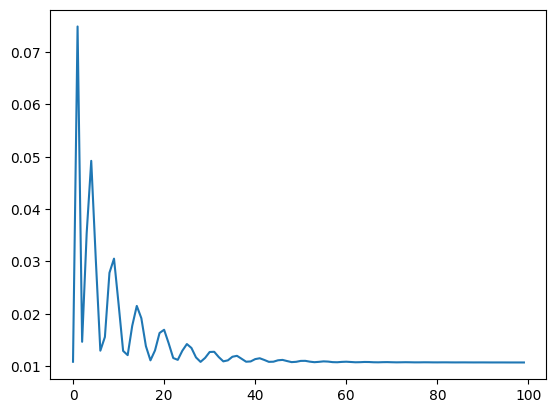

In [208]:
hidden_size = 32
rnn = SimpleRNN(hidden_size)

num_epochs = 100
sequence_length = 10
criterion = nn.MSELoss()

# generate data
t, y, train_data = generate_sin_data(0.1)

# turn data into sequences of length 10
# want: (batch_size=x, seq_len=10, input_size=1)
t_sequences = get_sequences_from_data(t, sequence_length)
train_data_sequences = get_sequences_from_data(train_data, sequence_length)

t_sequences = torch.FloatTensor(np.array(t_sequences)).unsqueeze(2)
train_data_sequences = torch.FloatTensor(np.array(train_data_sequences)).unsqueeze(2)


# train model
losses = []
opt = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):

    predictions = model(t_sequences)
    loss = criterion(predictions, train_data_sequences)

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())

plt.plot(losses)

Text(0.5, 1.0, 'RNN on Sequences of Length 10')

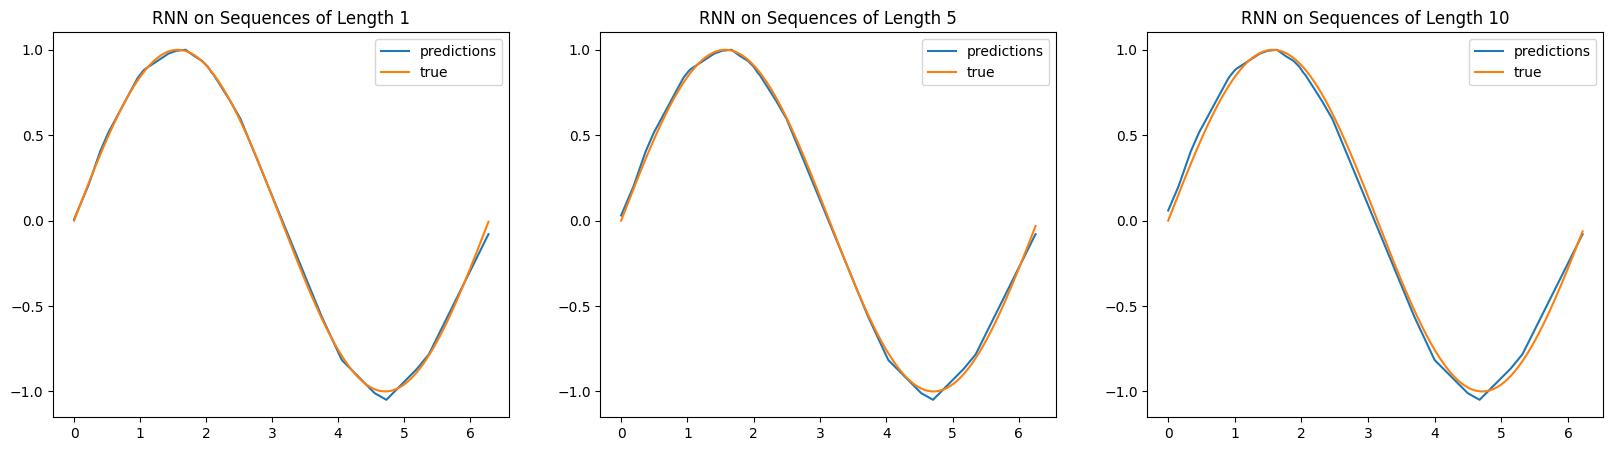

In [209]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# sequences of 1
t_sequences = get_sequences_from_data(t, 1)
t_sequences = torch.FloatTensor(np.array(t_sequences)).unsqueeze(2)
predictions = model(t_sequences)[:, -1, :].detach().numpy().squeeze()

axs[0].plot(t[:999], predictions, label="predictions")
axs[0].plot(t[:999], y[:999], label="true")
axs[0].legend(loc="upper right")
axs[0].set_title("RNN on Sequences of Length 1")

# sequences of 5
t_sequences = get_sequences_from_data(t, 5)
t_sequences = torch.FloatTensor(np.array(t_sequences)).unsqueeze(2)
predictions = model(t_sequences)[:, -1, :].detach().numpy().squeeze()

axs[1].plot(t[:995], predictions, label="predictions")
axs[1].plot(t[:995], y[:995], label="true")
axs[1].legend(loc="upper right")
axs[1].set_title("RNN on Sequences of Length 5")

# sequences of 10
t_sequences = get_sequences_from_data(t, 10)
t_sequences = torch.FloatTensor(np.array(t_sequences)).unsqueeze(2)
predictions = model(t_sequences)[:, -1, :].detach().numpy().squeeze()

axs[2].plot(t[:990], predictions, label="predictions")
axs[2].plot(t[:990], y[:990], label="true")
axs[2].legend(loc="upper right")
axs[2].set_title("RNN on Sequences of Length 10")
